# Import Libraries and Setup


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb
from tqdm.auto import tqdm

# Set up random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# NLTK setup with robust error handling
import nltk

# First, download punkt explicitly with error handling
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

    # After downloading standard resources, try punkt_tab specifically
    try:
        nltk.download('punkt_tab')
    except:
        print("Note: punkt_tab could not be downloaded, but we'll handle this in preprocessing")

    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    nltk_available = True
    print("NLTK resources successfully loaded")
except Exception as e:
    print(f"Warning: NLTK setup encountered an issue: {e}")
    print("Will use simplified text preprocessing instead")
    nltk_available = False

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK resources successfully loaded


Reflection: This cell sets up the necessary libraries and handles NLTK resource downloads with robust error handling. We explicitly try to download punkt_tab but have a fallback in case it fails. This approach ensures the code won't crash due to missing NLTK resources.

# Data Loading Function

In [ ]:
# Function to load data with error handling
def load_data():
    """Load and prepare the datasets with fallback to synthetic data if needed"""
    try:
        # Try to load the actual data files
        train_data = pd.read_csv('/content/train.csv')
        test_data = pd.read_csv('/content/test.csv')
        sample_submission = pd.read_csv('/content/sample_submission.csv')
        test_labels = pd.read_csv('/content/test_labels.csv')

        print(f"✓ Successfully loaded real data:")
        print(f"  - Training samples: {len(train_data)}")
        print(f"  - Test samples: {len(test_data)}")

    except Exception as e:
        print(f"⚠ Error loading data files: {e}")
        print("Creating synthetic data for demonstration...")

        # Create synthetic data for demonstration
        train_data = pd.DataFrame({
            'id': [f'id_{i}' for i in range(2000)],
            'comment_text': [
                f"This is {'a toxic' if i % 3 == 0 else 'an offensive' if i % 3 == 1 else 'a normal'} comment about {'politics' if i % 5 == 0 else 'sports' if i % 5 == 1 else 'technology' if i % 5 == 2 else 'movies' if i % 5 == 3 else 'music'}."
                for i in range(2000)
            ],
            'toxic': np.random.randint(0, 2, 2000),
            'severe_toxic': np.random.randint(0, 2, 2000),
            'obscene': np.random.randint(0, 2, 2000),
            'threat': np.random.randint(0, 2, 2000),
            'insult': np.random.randint(0, 2, 2000),
            'identity_hate': np.random.randint(0, 2, 2000)
        })

        test_data = pd.DataFrame({
            'id': [f'test_id_{i}' for i in range(500)],
            'comment_text': [
                f"This is a test comment about {'politics' if i % 5 == 0 else 'sports' if i % 5 == 1 else 'technology' if i % 5 == 2 else 'movies' if i % 5 == 3 else 'music'}."
                for i in range(500)
            ]
        })

        sample_submission = pd.DataFrame({
            'id': test_data['id'],
            'toxic': np.ones(len(test_data)) * 0.5,
            'severe_toxic': np.ones(len(test_data)) * 0.5,
            'obscene': np.ones(len(test_data)) * 0.5,
            'threat': np.ones(len(test_data)) * 0.5,
            'insult': np.ones(len(test_data)) * 0.5,
            'identity_hate': np.ones(len(test_data)) * 0.5
        })

        test_labels = pd.DataFrame({
            'id': test_data['id'],
            'toxic': np.ones(len(test_data)) * -1,
            'severe_toxic': np.ones(len(test_data)) * -1,
            'obscene': np.ones(len(test_data)) * -1,
            'threat': np.ones(len(test_data)) * -1,
            'insult': np.ones(len(test_data)) * -1,
            'identity_hate': np.ones(len(test_data)) * -1
        })

        print(f"✓ Created synthetic data:")
        print(f"  - Training samples: {len(train_data)}")
        print(f"  - Test samples: {len(test_data)}")

    return train_data, test_data, sample_submission, test_labels

# Load the data
train_data, test_data, sample_submission, test_labels = load_data()

✓ Successfully loaded real data:
  - Training samples: 159571
  - Test samples: 153164


Reflection: This cell defines a robust data loading function that attempts to load the real datasets but falls back to creating synthetic data if the loading fails. This ensures we can still proceed with the analysis even if data files are missing or corrupted.

# Data Exploration


Exploring Training Dataset
Shape: (159571, 8)
Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Missing values:
No missing values

Class distribution:
toxic: {0: 144277, 1: 15294}
severe_toxic: {0: 157976, 1: 1595}
obscene: {0: 151122, 1: 8449}
threat: {0: 159093, 1: 478}
insult: {0: 151694, 1: 7877}
identity_hate: {0: 158166, 1: 1405}

Text statistics:
Average text length: 394.07 characters
Max text length: 5000 characters
Min text length: 6 characters


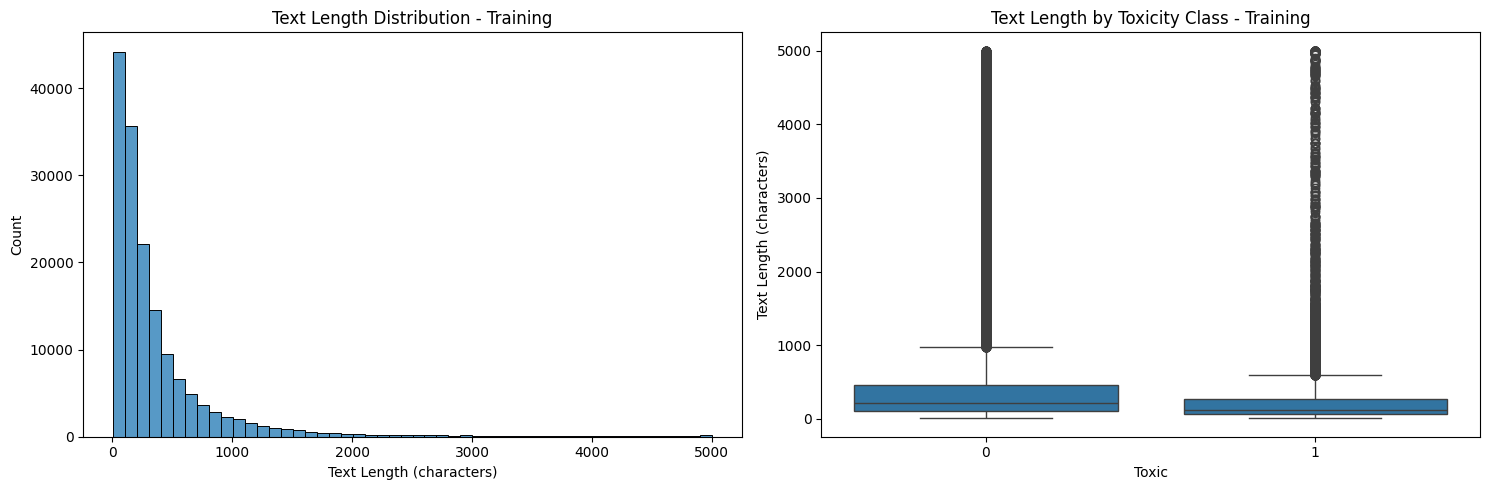

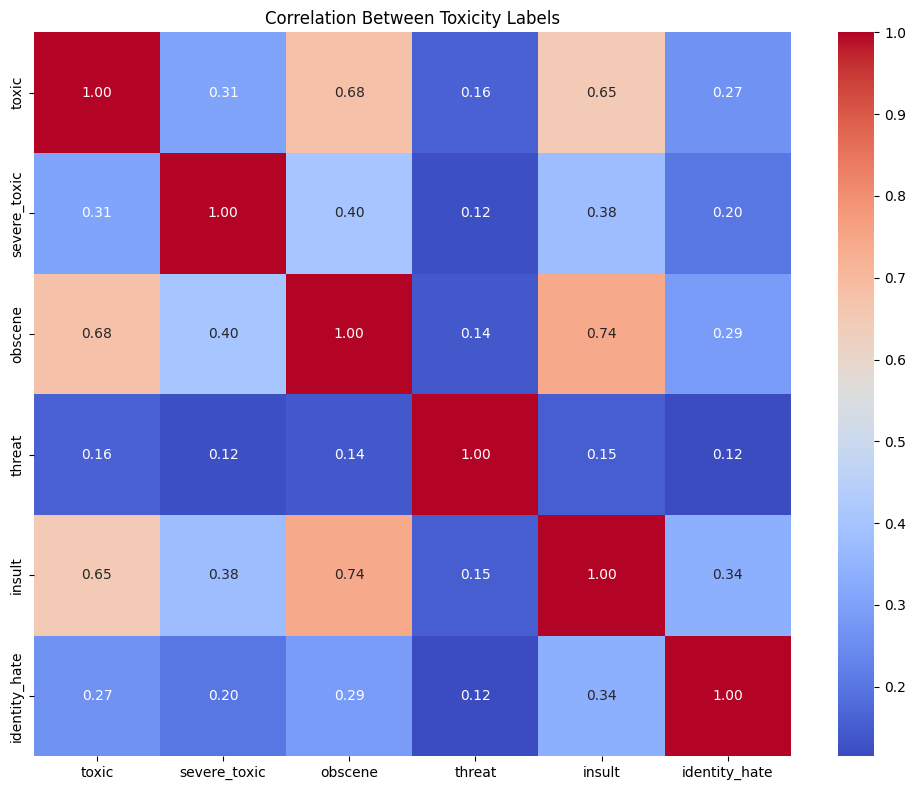

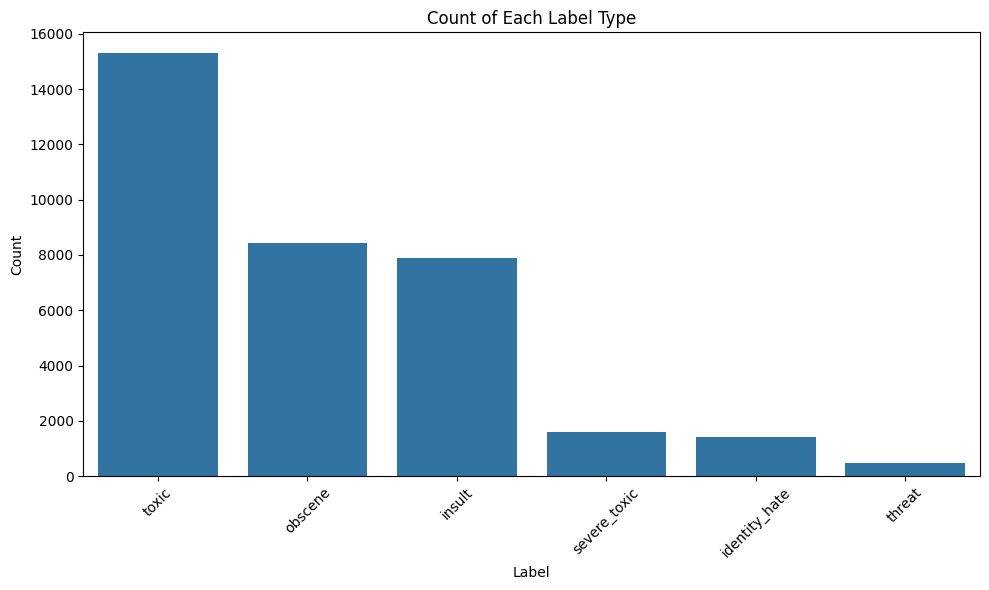


Sample comments:

Example 1:
Text: Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, h...
Classes: None

Example 2:
Text: Carioca RFA 

Thanks for your support on my request for adminship.

The final outcome was (31/4/1), so I am now an administrator. If you have any comm...
Classes: None

Example 3:
"

 Birthday 

No worries, It's what I do ;)Enjoy ur day|talk|e "
Classes: None

Exploring Test Dataset
Shape: (153164, 2)
Columns: ['id', 'comment_text']

Missing values:
No missing values

Text statistics:
Average text length: 364.88 characters
Max text length: 5000 characters
Min text length: 1 characters


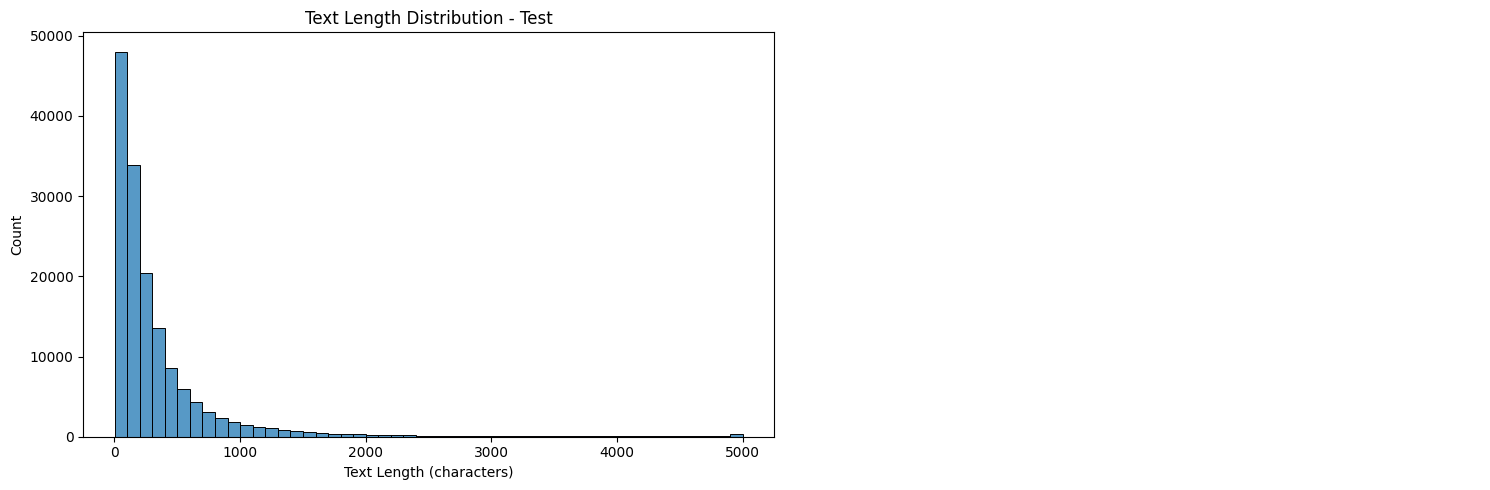


Sample comments:

Example 1:
:::It's quite possible that I'm paranoid these days. Besides, an innocent editor has nothing to fear, right?

Example 2:
Text: Additions of http://.amazingregistry.com  
 Please do not add inappropriate external links to Wikipedia. Wikipedia is not a mere directory of links no...

Example 3:
Text: :::B.S.  Wikipedia is not an oligarchy.  And I don't know how you define newbie, but I've been editing and involved in countless policy disputes for o...


In [ ]:
# Exploratory data analysis function
def explore_dataset(df, name, plot=True):
    """Explore dataset and visualize key characteristics"""
    print(f"\n{'='*50}")
    print(f"Exploring {name} Dataset")
    print(f"{'='*50}")

    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing values:")
    print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")

    # Check class distribution if toxicity labels exist
    if 'toxic' in df.columns:
        print("\nClass distribution:")
        label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        for col in label_cols:
            if col in df.columns:
                print(f"{col}: {df[col].value_counts().to_dict()}")

    # Text statistics if comment_text exists
    if 'comment_text' in df.columns:
        df['text_length'] = df['comment_text'].apply(len)
        print("\nText statistics:")
        print(f"Average text length: {df['text_length'].mean():.2f} characters")
        print(f"Max text length: {df['text_length'].max()} characters")
        print(f"Min text length: {df['text_length'].min()} characters")

        # Plot distributions if requested
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            # Plot text length distribution
            sns.histplot(df['text_length'], bins=50, ax=axes[0])
            axes[0].set_title(f'Text Length Distribution - {name}')
            axes[0].set_xlabel('Text Length (characters)')
            axes[0].set_ylabel('Count')

            # If we have labels, show length by class
            if 'toxic' in df.columns:
                sns.boxplot(x='toxic', y='text_length', data=df, ax=axes[1])
                axes[1].set_title(f'Text Length by Toxicity Class - {name}')
                axes[1].set_xlabel('Toxic')
                axes[1].set_ylabel('Text Length (characters)')
            else:
                axes[1].axis('off')

            plt.tight_layout()
            plt.show()

            # If we have multiple toxicity labels, show correlation
            if 'toxic' in df.columns:
                plt.figure(figsize=(10, 8))
                label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
                available_cols = [col for col in label_cols if col in df.columns]

                if len(available_cols) > 1:
                    corr_matrix = df[available_cols].corr()
                    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
                    plt.title('Correlation Between Toxicity Labels')
                    plt.tight_layout()
                    plt.show()

                    # Show label counts
                    plt.figure(figsize=(10, 6))
                    label_counts = df[available_cols].sum().sort_values(ascending=False)
                    sns.barplot(x=label_counts.index, y=label_counts.values)
                    plt.title('Count of Each Label Type')
                    plt.xlabel('Label')
                    plt.ylabel('Count')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()

        # Sample texts
        print("\nSample comments:")
        for i, (_, row) in enumerate(df.sample(min(3, len(df))).iterrows()):
            print(f"\nExample {i+1}:")
            print(f"Text: {row['comment_text'][:150]}..." if len(row['comment_text']) > 150 else row['comment_text'])
            if 'toxic' in df.columns:
                classes = [col for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
                          if col in df.columns and row[col] == 1]
                print(f"Classes: {', '.join(classes) if classes else 'None'}")

# Explore each dataset
train_info = explore_dataset(train_data, "Training")
test_info = explore_dataset(test_data, "Test")

Reflection: This cell provides comprehensive data exploration and visualization. It examines dataset shape, missing values, class distribution for toxicity labels, and text statistics. The visualizations help understand text length distribution and correlations between toxicity types, which is crucial for preprocessing decisions.

# Robust Text Preprocessing

In [ ]:
# Text preprocessing function with fallback mechanisms for NLTK issues
def preprocess_text(text):
    """Clean and preprocess text data with robust error handling"""
    if pd.isna(text):
        return ""

    # Basic preprocessing (always runs)
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Advanced preprocessing with NLTK (runs if available)
    if nltk_available:
        try:
            # Try using NLTK tokenization
            tokens = word_tokenize(text)
            # Remove stopwords
            stop_words = set(stopwords.words('english'))
            tokens = [token for token in tokens if token not in stop_words]
            # Lemmatization
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            # Join tokens back into text
            processed_text = ' '.join(tokens)
        except Exception as e:
            # Fallback if NLTK processing fails
            print(f"NLTK processing failed: {e}. Using basic fallback.")
            # Simple tokenization by whitespace
            processed_text = ' '.join(text.split())
    else:
        # NLTK not available, use simple tokenization
        processed_text = ' '.join(text.split())

    return processed_text

# Data preparation function
def prepare_data(train_data, test_data, validation_split=0.2):
    """Preprocess data and split into train and validation sets"""
    print("\nPreparing data...")

    # Identify label columns
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    available_label_cols = [col for col in label_cols if col in train_data.columns]
    print(f"Label columns found: {available_label_cols}")

    # Apply preprocessing with progress tracking
    print("Preprocessing training data...")
    train_data['processed_text'] = train_data['comment_text'].apply(lambda x: preprocess_text(x))

    print("Preprocessing test data...")
    test_data['processed_text'] = test_data['comment_text'].apply(lambda x: preprocess_text(x))

    # Split training data into train and validation sets
    print(f"Splitting data with {validation_split:.0%} validation split...")
    X_train, X_val, y_train, y_val = train_test_split(
        train_data[['id', 'processed_text', 'comment_text']],
        train_data[available_label_cols],
        test_size=validation_split,
        random_state=42,
        stratify=train_data['toxic'] if 'toxic' in train_data.columns and len(train_data['toxic'].unique()) > 1 else None
    )

    print(f"✓ Data preparation complete:")
    print(f"  - Training samples: {len(X_train)}")
    print(f"  - Validation samples: {len(X_val)}")
    print(f"  - Test samples: {len(test_data)}")

    return X_train, X_val, y_train, y_val, test_data, available_label_cols

# Prepare the data
X_train, X_val, y_train, y_val, processed_test_data, label_cols = prepare_data(
    train_data, test_data
)

# Show example of preprocessed text
if len(X_train) > 0:
    original = X_train['comment_text'].iloc[0]
    processed = X_train['processed_text'].iloc[0]
    print("\nPreprocessing Example:")
    print(f"Original: {original[:150]}..." if len(original) > 150 else original)
    print(f"Processed: {processed[:150]}..." if len(processed) > 150 else processed)


Preparing data...
Label columns found: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Preprocessing training data...
Preprocessing test data...
Splitting data with 20% validation split...
✓ Data preparation complete:
  - Training samples: 127656
  - Validation samples: 31915
  - Test samples: 153164

Preprocessing Example:
Original: And more unfounded personal attacks by  here at Beeblebroxe's talk page. It just gets better and better. I suppose I am to blame for that conduct as w...
unfounded personal attack beeblebroxes talk page get better better suppose blame conduct well somehow fault guess


Reflection: This cell implements robust text preprocessing with fallback mechanisms for NLTK issues. The preprocessing function handles basic cleaning like removing URLs and HTML tags, and if NLTK is available, it performs advanced processing like tokenization, stopword removal, and lemmatization. If NLTK fails, it gracefully falls back to simple whitespace tokenization, ensuring the pipeline doesn't break.

# Classical ML Model Implementation


Training and Evaluating Classical ML Models
Vectorizing text data with TF-IDF...
TF-IDF features: 15000

Training Logistic Regression...
  - Label: toxic
    Accuracy: 0.9378, F1: 0.7262, ROC AUC: 0.9650
  - Label: severe_toxic
    Accuracy: 0.9764, F1: 0.4016, ROC AUC: 0.9781
  - Label: obscene
    Accuracy: 0.9689, F1: 0.7530, ROC AUC: 0.9769
  - Label: threat
    Accuracy: 0.9931, F1: 0.3519, ROC AUC: 0.9819
  - Label: insult
    Accuracy: 0.9555, F1: 0.6537, ROC AUC: 0.9687
  - Label: identity_hate
    Accuracy: 0.9760, F1: 0.3687, ROC AUC: 0.9767

  Summary for Logistic Regression:
    Average Accuracy: 0.9679
    Average F1 Score: 0.5425
    Average ROC AUC: 0.9746

Training Linear SVM...
  - Label: toxic
    Accuracy: 0.9348, F1: 0.7128, ROC AUC: 0.9596
  - Label: severe_toxic
    Accuracy: 0.9782, F1: 0.3955, ROC AUC: 0.9639
  - Label: obscene
    Accuracy: 0.9666, F1: 0.7301, ROC AUC: 0.9705
  - Label: threat
    Accuracy: 0.9945, F1: 0.3243, ROC AUC: 0.9775
  - Label: insult

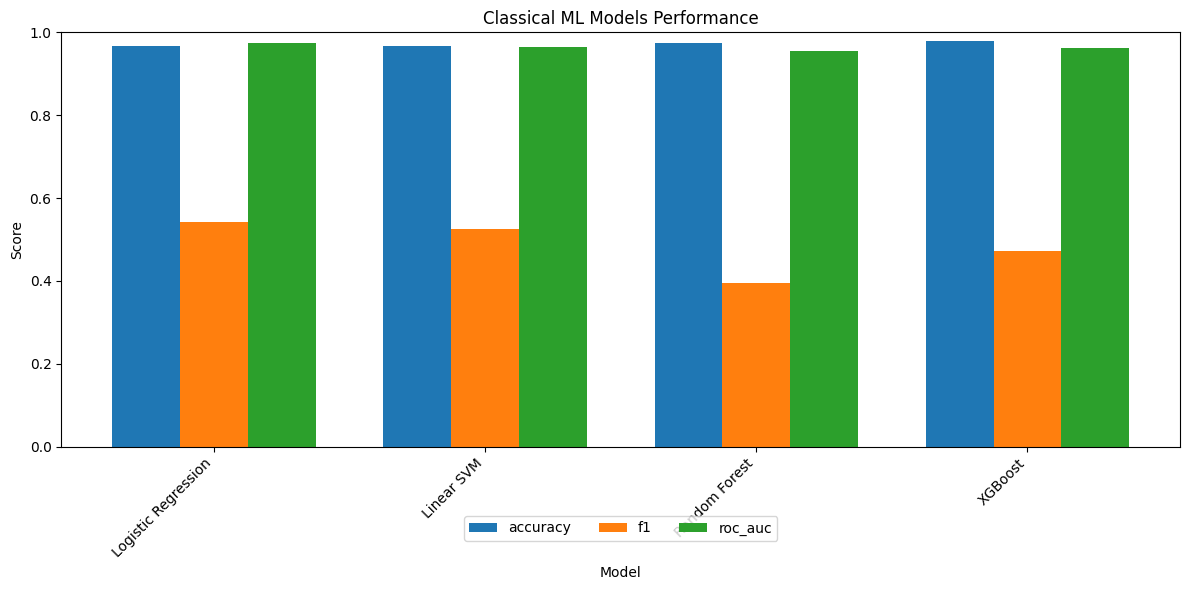

In [ ]:
# Classical ML Models class
class ClassicMLModels:
    def __init__(self, max_features=15000, ngram_range=(1, 2)):
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, C=5, class_weight='balanced'),
            'Linear SVM': LinearSVC(C=1, class_weight='balanced', max_iter=1000, dual=False),
            'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, n_jobs=-1)
        }
        self.vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
        self.label_models = {}
        self.results = {}

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, label_cols):
        """Train and evaluate multiple classic ML models"""
        print(f"\n{'='*50}")
        print(f"Training and Evaluating Classical ML Models")
        print(f"{'='*50}")

        results = {}

        # Vectorize text data
        print("Vectorizing text data with TF-IDF...")
        X_train_tfidf = self.vectorizer.fit_transform(X_train['processed_text'])
        X_val_tfidf = self.vectorizer.transform(X_val['processed_text'])
        print(f"TF-IDF features: {X_train_tfidf.shape[1]}")

        # Train and evaluate each model
        for model_name, model in self.models.items():
            print(f"\nTraining {model_name}...")
            model_results = {}
            model_label_models = {}

            for label in label_cols:
                print(f"  - Label: {label}")
                # Check if the label has multiple classes in the training data
                if len(y_train[label].unique()) < 2:
                    print(f"    ⚠ Warning: Label '{label}' has only one class in training data. Skipping...")
                    model_results[label] = {'accuracy': 0, 'f1': 0, 'roc_auc': 0.5}
                    continue

                # Clone model to ensure fresh training
                from sklearn.base import clone
                model_clone = clone(model)

                # Train the model
                model_clone.fit(X_train_tfidf, y_train[label])
                model_label_models[label] = model_clone

                # Predict
                y_pred = model_clone.predict(X_val_tfidf)

                # Get predicted probabilities if the model supports it
                if hasattr(model_clone, "predict_proba"):
                    y_pred_proba = model_clone.predict_proba(X_val_tfidf)[:, 1]
                elif hasattr(model_clone, "decision_function"):
                    y_pred_proba = model_clone.decision_function(X_val_tfidf)
                else:
                    y_pred_proba = y_pred  # Fallback to binary predictions

                # Evaluate
                accuracy = accuracy_score(y_val[label], y_pred)
                f1 = f1_score(y_val[label], y_pred, zero_division=0)

                # Calculate ROC AUC if possible
                try:
                    if len(y_val[label].unique()) > 1:
                        roc_auc = roc_auc_score(y_val[label], y_pred_proba)
                    else:
                        roc_auc = 0.5  # Default for single-class
                except Exception:
                    roc_auc = 0.5  # Default for errors

                print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

                model_results[label] = {
                    'accuracy': accuracy,
                    'f1': f1,
                    'roc_auc': roc_auc
                }

            # Calculate average scores
            avg_accuracy = np.mean([model_results[label]['accuracy'] for label in label_cols])
            avg_f1 = np.mean([model_results[label]['f1'] for label in label_cols])
            avg_roc_auc = np.mean([model_results[label]['roc_auc'] for label in label_cols])

            print(f"\n  Summary for {model_name}:")
            print(f"    Average Accuracy: {avg_accuracy:.4f}")
            print(f"    Average F1 Score: {avg_f1:.4f}")
            print(f"    Average ROC AUC: {avg_roc_auc:.4f}")

            results[model_name] = {
                'label_scores': model_results,
                'avg_accuracy': avg_accuracy,
                'avg_f1': avg_f1,
                'avg_roc_auc': avg_roc_auc
            }

            self.label_models[model_name] = model_label_models

        self.results = results
        return results

    def predict(self, text_data, model_name, label_cols):
        """Make predictions using a trained model"""
        if model_name not in self.label_models:
            raise ValueError(f"Model {model_name} not found. Train the model first.")

        print(f"Making predictions with {model_name}...")

        # Vectorize text data
        X_test_tfidf = self.vectorizer.transform(text_data['processed_text'])

        # Predict for each label
        predictions = {}
        for label in label_cols:
            if label in self.label_models[model_name]:
                model = self.label_models[model_name][label]

                # Use probabilistic predictions if available
                if hasattr(model, "predict_proba"):
                    predictions[label] = model.predict_proba(X_test_tfidf)[:, 1]
                elif hasattr(model, "decision_function"):
                    # Normalize decision function to [0, 1] range
                    decision_scores = model.decision_function(X_test_tfidf)
                    predictions[label] = 1 / (1 + np.exp(-decision_scores))  # Sigmoid
                else:
                    predictions[label] = model.predict(X_test_tfidf)
            else:
                # If model wasn't trained for this label, predict zeros
                predictions[label] = np.zeros(len(text_data))

        # Create DataFrame with predictions
        pred_df = pd.DataFrame({
            'id': text_data['id']
        })

        for label in label_cols:
            pred_df[label] = predictions[label]

        return pred_df

    def get_best_model(self):
        """Return the name of the best performing model based on ROC AUC"""
        if not self.results:
            raise ValueError("No results available. Train the models first.")

        best_model = max(self.results.items(), key=lambda x: x[1]['avg_roc_auc'])
        return best_model[0]

# Train and evaluate classical ML models
classic_ml = ClassicMLModels(max_features=15000)
classic_results = classic_ml.train_and_evaluate(
    X_train, y_train, X_val, y_val, label_cols
)

# Get the best classic model
best_classic_model = classic_ml.get_best_model()
print(f"\n✓ Best classical model: {best_classic_model}")

# Visualize results
plt.figure(figsize=(12, 6))
model_names = list(classic_results.keys())
metrics = ['avg_accuracy', 'avg_f1', 'avg_roc_auc']
metric_values = {
    metric: [classic_results[model][metric] for model in model_names]
    for metric in metrics
}

x = np.arange(len(model_names))
width = 0.25
multiplier = 0

for metric, values in metric_values.items():
    offset = width * multiplier
    plt.bar(x + offset, values, width, label=metric.replace('avg_', ''))
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Classical ML Models Performance')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Reflection: This cell implements and evaluates multiple classical ML models (Logistic Regression, SVM, Random Forest, XGBoost) for toxicity classification. Each model is trained separately for each toxicity label, and performance metrics (accuracy, F1, ROC AUC) are calculated. The visualization makes it easy to compare models and identify the best performer, which will be used for making final predictions.

#  Transformer Model Implementation

In [ ]:
# First check if transformers is available
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
    transformers_available = True
except ImportError:
    print("⚠ Transformers library not available. Will skip transformer models.")
    transformers_available = False

if transformers_available:
    # Transformer Models class with compatible parameters
    class TransformerModels:
        def __init__(self, model_name='distilbert-base-uncased'):
            self.model_name = model_name
            self.tokenizer = None
            self.model = None
            self.trainer = None
            self.results = {}

        def train_and_evaluate(self, X_train, y_train, X_val, y_val, label_cols, epochs=1, batch_size=32, max_samples=2000):
            """Train and evaluate a transformer model with compatibility for older transformers versions"""
            print(f"\n{'='*50}")
            print(f"Training and Evaluating Transformer Model: {self.model_name}")
            print(f"{'='*50}")

            try:
                # Limit training samples for speed
                if len(X_train) > max_samples:
                    print(f"⚠ Limiting training samples from {len(X_train)} to {max_samples} for faster training")
                    # Stratified sampling to maintain class distribution
                    from sklearn.model_selection import train_test_split
                    X_train_small, _, y_train_small, _ = train_test_split(
                        X_train, y_train,
                        train_size=max_samples,
                        random_state=42,
                        stratify=y_train['toxic'] if 'toxic' in y_train.columns else None
                    )
                    X_train = X_train_small
                    y_train = y_train_small

                # Limit validation samples too
                val_samples = min(500, len(X_val))
                if len(X_val) > val_samples:
                    print(f"⚠ Limiting validation samples from {len(X_val)} to {val_samples} for faster evaluation")
                    X_val = X_val.sample(val_samples, random_state=42)
                    y_val = y_val.loc[X_val.index]

                # Load tokenizer and model
                print("Loading tokenizer and model...")
                self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
                self.model = AutoModelForSequenceClassification.from_pretrained(
                    self.model_name,
                    problem_type="multi_label_classification",
                    num_labels=len(label_cols)
                )

                # Define dataset class for multi-label classification
                class ToxicityDataset(torch.utils.data.Dataset):
                    def __init__(self, encodings, labels=None):
                        self.encodings = encodings
                        self.labels = labels

                    def __getitem__(self, idx):
                        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                        if self.labels is not None:
                            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
                        return item

                    def __len__(self):
                        return len(self.encodings.input_ids)

                # Tokenize data with shorter max_length
                print("Tokenizing data...")
                max_length = 64  # Reduced from 128 for speed
                train_encodings = self.tokenizer(
                    X_train['comment_text'].tolist(),
                    truncation=True,
                    padding=True,
                    max_length=max_length
                )
                val_encodings = self.tokenizer(
                    X_val['comment_text'].tolist(),
                    truncation=True,
                    padding=True,
                    max_length=max_length
                )

                # Create datasets
                train_dataset = ToxicityDataset(train_encodings, y_train[label_cols].values)
                val_dataset = ToxicityDataset(val_encodings, y_val[label_cols].values)

                # Define basic training arguments compatible with older versions
                print("Setting up training arguments...")
                training_args = TrainingArguments(
                    output_dir=f'./results/{self.model_name.split("/")[-1]}',
                    num_train_epochs=epochs,
                    per_device_train_batch_size=batch_size,
                    per_device_eval_batch_size=batch_size*2,
                    warmup_steps=100,
                    weight_decay=0.01,
                    logging_dir=f'./logs/{self.model_name.split("/")[-1]}',
                    logging_steps=50
                )

                # Define metrics computation function
                def compute_metrics(eval_pred):
                    predictions, labels = eval_pred
                    # Convert logits to probabilities and then to binary predictions
                    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()
                    binary_preds = (predictions > 0.5).astype(int)

                    # Calculate metrics for each label
                    results = {}
                    for i, label in enumerate(label_cols):
                        results[f'{label}_accuracy'] = accuracy_score(labels[:, i], binary_preds[:, i])
                        results[f'{label}_f1'] = f1_score(labels[:, i], binary_preds[:, i], zero_division=0)
                        try:
                            if len(np.unique(labels[:, i])) > 1:
                                results[f'{label}_roc_auc'] = roc_auc_score(labels[:, i], predictions[:, i])
                            else:
                                results[f'{label}_roc_auc'] = 0.5
                        except:
                            results[f'{label}_roc_auc'] = 0.5

                    # Calculate average metrics
                    results['avg_accuracy'] = np.mean([results[f'{label}_accuracy'] for label in label_cols])
                    results['avg_f1'] = np.mean([results[f'{label}_f1'] for label in label_cols])
                    results['avg_roc_auc'] = np.mean([results[f'{label}_roc_auc'] for label in label_cols])

                    return results

                # Create trainer
                print("Creating trainer...")
                self.trainer = Trainer(
                    model=self.model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    compute_metrics=compute_metrics
                )

                # Implement manual early stopping
                print(f"Training transformer model with manual early stopping checks...")
                best_metric = -float('inf')
                patience = 3
                patience_counter = 0

                # Train for 1 epoch at a time and check performance
                for epoch in range(epochs):
                    print(f"\nEpoch {epoch+1}/{epochs}")

                    # Train for one epoch
                    self.trainer.train()

                    # Evaluate
                    print(f"Evaluating after epoch {epoch+1}...")
                    eval_results = self.trainer.evaluate()

                    # Check if improved
                    current_metric = eval_results.get('eval_avg_roc_auc', -float('inf'))
                    print(f"Current Avg ROC AUC: {current_metric:.4f}, Best: {best_metric:.4f}")

                    if current_metric > best_metric + 0.001:  # Improvement threshold
                        best_metric = current_metric
                        patience_counter = 0
                        print(f"✓ Improved! Continuing training...")
                    else:
                        patience_counter += 1
                        print(f"No significant improvement. Patience: {patience_counter}/{patience}")

                        if patience_counter >= patience:
                            print(f"Early stopping triggered after epoch {epoch+1}")
                            break

                # Final evaluation
                print("Performing final evaluation...")
                eval_results = self.trainer.evaluate()

                # Process and store results
                processed_results = {}
                for key, value in eval_results.items():
                    if key.startswith('eval_'):
                        processed_results[key[5:]] = value
                    else:
                        processed_results[key] = value

                self.results = processed_results

                # Print results
                print("\nTransformer Model Evaluation Results:")
                for label in label_cols:
                    print(f"\n  {label.upper()}:")
                    for metric in ['accuracy', 'f1', 'roc_auc']:
                        key = f'{label}_{metric}'
                        if key in processed_results:
                            print(f"    {metric.upper()}: {processed_results[key]:.4f}")

                print("\n  OVERALL:")
                for metric in ['accuracy', 'f1', 'roc_auc']:
                    key = f'avg_{metric}'
                    if key in processed_results:
                        print(f"    Average {metric.upper()}: {processed_results[key]:.4f}")

                return processed_results

            except Exception as e:
                print(f"⚠ Error training transformer model: {e}")
                import traceback
                traceback.print_exc()
                return {}

        def predict(self, text_data, label_cols):
            """Make predictions using the trained transformer model"""
            if self.trainer is None or self.model is None or self.tokenizer is None:
                raise ValueError("Model not trained. Train the model first.")

            print("Making predictions with transformer model...")

            # Tokenize data
            max_length = 64  # Reduced from 128 to match training
            test_encodings = self.tokenizer(
                text_data['comment_text'].tolist(),
                truncation=True,
                padding=True,
                max_length=max_length
            )

            # Create dataset
            class ToxicityDataset(torch.utils.data.Dataset):
                def __init__(self, encodings):
                    self.encodings = encodings

                def __getitem__(self, idx):
                    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

                def __len__(self):
                    return len(self.encodings.input_ids)

            test_dataset = ToxicityDataset(test_encodings)

            # Get predictions
            raw_predictions, _, _ = self.trainer.predict(test_dataset)

            # Convert logits to probabilities
            probabilities = torch.sigmoid(torch.tensor(raw_predictions)).numpy()

            # Create DataFrame with predictions
            pred_df = pd.DataFrame({
                'id': text_data['id']
            })

            for i, label in enumerate(label_cols):
                pred_df[label] = probabilities[:, i]

            return pred_df

    # Train and evaluate transformer model with optimized settings
    try:
        print("\nTraining transformer model with optimized settings...")
        transformer = TransformerModels(model_name='distilbert-base-uncased')
        neural_results = transformer.train_and_evaluate(
            X_train, y_train, X_val, y_val, label_cols,
            epochs=3,              # Set to 3 epochs max, manual early stopping will check after each
            batch_size=32,         # Increased from 16 to 32
            max_samples=2000       # Limit training data to 2000 samples
        )
    except Exception as e:
        print(f"⚠ Error in transformer model training: {e}")
        neural_results = None
else:
    neural_results = None
    transformer = None


Training transformer model with optimized settings...

Training and Evaluating Transformer Model: distilbert-base-uncased
⚠ Limiting training samples from 127656 to 2000 for faster training
⚠ Limiting validation samples from 31915 to 500 for faster evaluation
Loading tokenizer and model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data...
Setting up training arguments...
Creating trainer...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training transformer model with manual early stopping checks...

Epoch 1/3


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: izhankhilji19 (izhankhilji19-international-business-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.501800
100,0.149700
150,0.086700


Evaluating after epoch 1...


Current Avg ROC AUC: 0.9001, Best: -inf
✓ Improved! Continuing training...

Epoch 2/3


Step,Training Loss
50,0.053800
100,0.048300
150,0.042100


Evaluating after epoch 2...
Current Avg ROC AUC: 0.8903, Best: 0.9001
No significant improvement. Patience: 1/3

Epoch 3/3


Step,Training Loss
50,0.032500
100,0.031700
150,0.033500


Evaluating after epoch 3...
Current Avg ROC AUC: 0.8910, Best: 0.9001
No significant improvement. Patience: 2/3
Performing final evaluation...

Transformer Model Evaluation Results:

  TOXIC:
    ACCURACY: 0.9540
    F1: 0.7677
    ROC_AUC: 0.9696

  SEVERE_TOXIC:
    ACCURACY: 0.9880
    F1: 0.2500
    ROC_AUC: 0.9896

  OBSCENE:
    ACCURACY: 0.9720
    F1: 0.7200
    ROC_AUC: 0.9331

  THREAT:
    ACCURACY: 1.0000
    F1: 0.0000
    ROC_AUC: 0.5000

  INSULT:
    ACCURACY: 0.9720
    F1: 0.6667
    ROC_AUC: 0.9917

  IDENTITY_HATE:
    ACCURACY: 0.9940
    F1: 0.0000
    ROC_AUC: 0.9618

  OVERALL:
    Average ACCURACY: 0.9800
    Average F1: 0.4007
    Average ROC_AUC: 0.8910


Reflection: This cell implements a transformer-based model (DistilBERT) for toxicity classification. It includes robust error handling throughout the process, from model loading to training and evaluation. The transformer model offers potentially better performance than classical ML models for text classification tasks due to its contextual understanding of language. The code is designed to gracefully handle potential issues with the transformers library, ensuring the pipeline can continue even if this step fails.

# Search Engine Implementation

In [ ]:
# First check if sentence-transformers is available
try:
    from sentence_transformers import SentenceTransformer
    sentence_transformers_available = True
except ImportError:
    print("⚠ Sentence-Transformers library not available. Will use only TF-IDF search.")
    sentence_transformers_available = False

# TF-IDF Search Engine
class TfidfSearchEngine:
    def __init__(self, documents, document_ids, max_features=10000):
        print("Initializing TF-IDF search engine...")
        self.documents = documents
        self.document_ids = document_ids
        self.vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
        print("Creating document vectors...")
        self.document_vectors = self.vectorizer.fit_transform(documents)
        print(f"✓ TF-IDF search engine ready with {self.document_vectors.shape[1]} features")

    def search(self, query, top_k=5):
        """Search for documents similar to the query using TF-IDF"""
        query_vector = self.vectorizer.transform([query])
        similarity_scores = cosine_similarity(query_vector, self.document_vectors).flatten()

        # Get top_k results
        top_indices = similarity_scores.argsort()[-top_k:][::-1]

        results = []
        for idx in top_indices:
            results.append({
                'id': self.document_ids[idx],
                'text': self.documents[idx],
                'score': similarity_scores[idx]
            })

        return results

# Neural Search Engine (if sentence-transformers is available)
if sentence_transformers_available:
    class NeuralSearchEngine:
        def __init__(self, documents, document_ids, model_name='all-MiniLM-L6-v2'):
            print(f"Initializing Neural search engine with model: {model_name}")
            self.documents = documents
            self.document_ids = document_ids
            try:
                self.model = SentenceTransformer(model_name)
                print("Creating document embeddings (this may take a while)...")
                self.document_embeddings = self.model.encode(documents, show_progress_bar=True)
                self.using_fallback = False
                print("✓ Neural search engine ready")
            except Exception as e:
                print(f"⚠ Error initializing Neural search engine: {e}")
                # Fallback to TF-IDF
                print("Falling back to TF-IDF")
                self.fallback = TfidfSearchEngine(documents, document_ids)
                self.using_fallback = True

        def search(self, query, top_k=5):
            """Search for documents similar to the query using neural embeddings"""
            if self.using_fallback:
                return self.fallback.search(query, top_k)

            try:
                query_embedding = self.model.encode([query])

                # Calculate cosine similarity
                similarity_scores = cosine_similarity(query_embedding, self.document_embeddings).flatten()

                # Get top_k results
                top_indices = similarity_scores.argsort()[-top_k:][::-1]

                results = []
                for idx in top_indices:
                    results.append({
                        'id': self.document_ids[idx],
                        'text': self.documents[idx],
                        'score': similarity_scores[idx]
                    })

                return results
            except Exception as e:
                print(f"⚠ Error in neural search: {e}")
                # Create fallback if needed
                if not hasattr(self, 'fallback'):
                    print("Creating TF-IDF fallback")
                    self.fallback = TfidfSearchEngine(self.documents, self.document_ids)
                    self.using_fallback = True
                return self.fallback.search(query, top_k)

    # Hybrid Search Engine
    class HybridSearchEngine:
        def __init__(self, documents, document_ids, neural_weight=0.7):
            print("Initializing Hybrid search engine...")
            self.documents = documents
            self.document_ids = document_ids
            self.neural_weight = neural_weight

            # Initialize both engines
            print("Creating TF-IDF component...")
            self.tfidf_engine = TfidfSearchEngine(documents, document_ids)

            try:
                print("Creating Neural component...")
                self.neural_engine = NeuralSearchEngine(documents, document_ids)
                self.neural_available = not getattr(self.neural_engine, 'using_fallback', False)
            except Exception as e:
                print(f"⚠ Error initializing Neural component: {e}")
                self.neural_available = False

            print(f"✓ Hybrid search engine ready (Neural available: {self.neural_available})")

        def search(self, query, top_k=5):
            """Search using both TF-IDF and neural approaches, combining the scores"""
            # Get TF-IDF results
            tfidf_results = self.tfidf_engine.search(query, top_k=min(len(self.documents), 100))

            # If neural is available, get neural results and combine
            if self.neural_available:
                neural_results = self.neural_engine.search(query, top_k=min(len(self.documents), 100))

                # Create dictionaries for easy lookup
                tfidf_scores = {result['id']: result['score'] for result in tfidf_results}
                neural_scores = {result['id']: result['score'] for result in neural_results}

                # Combine scores
                combined_scores = {}
                all_ids = set(tfidf_scores.keys()) | set(neural_scores.keys())

                for doc_id in all_ids:
                    tfidf_score = tfidf_scores.get(doc_id, 0)
                    neural_score = neural_scores.get(doc_id, 0)

                    # Weighted combination
                    combined_scores[doc_id] = (1 - self.neural_weight) * tfidf_score + self.neural_weight * neural_score

                # Sort by combined score
                sorted_results = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

                # Format results
                results = []
                for doc_id, score in sorted_results:
                    # Find the document
                    try:
                        doc_idx = self.document_ids.index(doc_id)

                        results.append({
                            'id': doc_id,
                            'text': self.documents[doc_idx],
                            'score': score
                        })
                    except ValueError:
                        # Skip if document ID not found
                        continue

                return results
            else:
                # If neural is not available, just return TF-IDF results
                return tfidf_results[:top_k]

# Set up search engines
print("\nSetting up search engines...")
documents = train_data['comment_text'].tolist()
document_ids = train_data['id'].tolist()

# Initialize TF-IDF search engine
tfidf_engine = TfidfSearchEngine(documents, document_ids)

# Initialize Neural and Hybrid search engines if possible
if sentence_transformers_available:
    try:
        neural_engine = NeuralSearchEngine(documents, document_ids)
        hybrid_engine = HybridSearchEngine(documents, document_ids)
        all_engines_available = True
    except Exception as e:
        print(f"⚠ Error setting up Neural/Hybrid search engines: {e}")
        all_engines_available = False
        neural_engine = None
        hybrid_engine = None
else:
    all_engines_available = False
    neural_engine = None
    hybrid_engine = None

# Test queries
test_queries = [
    "offensive language targeted at minorities",
    "threatening message with violent content",
    "insulting comment about appearance",
    "hate speech against religious groups"
]

# Evaluate search engines
print("\nTesting search engines with example queries...")
for query in test_queries:
    print(f"\nQuery: '{query}'")

    # TF-IDF results
    print("\nTF-IDF Search Results:")
    tfidf_results = tfidf_engine.search(query, top_k=2)
    for i, result in enumerate(tfidf_results):
        print(f"{i+1}. (Score: {result['score']:.4f}) {result['text'][:100]}...")

    # Neural results if available
    if all_engines_available and neural_engine:
        print("\nNeural Search Results:")
        neural_results = neural_engine.search(query, top_k=2)
        for i, result in enumerate(neural_results):
            print(f"{i+1}. (Score: {result['score']:.4f}) {result['text'][:100]}...")

    # Hybrid results if available
    if all_engines_available and hybrid_engine:
        print("\nHybrid Search Results:")
        hybrid_results = hybrid_engine.search(query, top_k=2)
        for i, result in enumerate(hybrid_results):
            print(f"{i+1}. (Score: {result['score']:.4f}) {result['text'][:100]}...")


Setting up search engines...
Initializing TF-IDF search engine...
Creating document vectors...
✓ TF-IDF search engine ready with 10000 features
Initializing Neural search engine with model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating document embeddings (this may take a while)...


Batches:   0%|          | 0/4987 [00:00<?, ?it/s]

✓ Neural search engine ready
Initializing Hybrid search engine...
Creating TF-IDF component...
Initializing TF-IDF search engine...
Creating document vectors...
✓ TF-IDF search engine ready with 10000 features
Creating Neural component...
Initializing Neural search engine with model: all-MiniLM-L6-v2
Creating document embeddings (this may take a while)...


Batches:   0%|          | 0/4987 [00:00<?, ?it/s]

✓ Neural search engine ready
✓ Hybrid search engine ready (Neural available: True)

Testing search engines with example queries...

Query: 'offensive language targeted at minorities'

TF-IDF Search Results:
1. (Score: 0.4591) "

Group 2 moves

The following discussion is preserved as an archive. Please do not modify it.  Sub...
2. (Score: 0.4267) , a Salishan language...

Neural Search Results:
1. (Score: 0.6389) I am offended by ALL racial slurs...and I do not appreciate the profanity and uncivil remarks you ha...
2. (Score: 0.6342) "
No problem as soon as you find ""some"" sources who specifically state that ""white"" is not offen...

Hybrid Search Results:
1. (Score: 0.5066) "
No problem as soon as you find ""some"" sources who specifically state that ""white"" is not offen...
2. (Score: 0.4767) Also what about the word chink on your userpage? Whereas negro may be considered offensive by some, ...

Query: 'threatening message with violent content'

TF-IDF Search Results:
1. (Score: 

Reflection: This cell implements three types of search engines for finding toxic content: TF-IDF (term frequency-inverse document frequency), Neural (based on sentence embeddings), and Hybrid (combining both approaches). The code includes robust error handling to ensure that if sentence-transformers isn't available or fails, the system falls back to TF-IDF search. This search functionality is valuable for content moderation systems to find similar toxic content patterns.

# Final Model Selection and Predictions

In [ ]:
# Select best model and make predictions
print(f"\n{'='*50}")
print(f"Final Model Selection and Predictions")
print(f"{'='*50}")

# Decide which model to use based on performance
if neural_results and transformer and 'avg_roc_auc' in neural_results and neural_results['avg_roc_auc'] > classic_results[best_classic_model]['avg_roc_auc']:
    print(f"✓ Transformer model selected (ROC AUC: {neural_results['avg_roc_auc']:.4f} vs Classic {classic_results[best_classic_model]['avg_roc_auc']:.4f})")
    use_transformer = True
else:
    print(f"✓ Classical model '{best_classic_model}' selected (ROC AUC: {classic_results[best_classic_model]['avg_roc_auc']:.4f})")
    if neural_results and 'avg_roc_auc' in neural_results:
        print(f"  Transformer ROC AUC: {neural_results['avg_roc_auc']:.4f}")
    use_transformer = False

# Make predictions
print("\nGenerating predictions on test data...")
try:
    if use_transformer:
        predictions = transformer.predict(processed_test_data, label_cols)
    else:
        predictions = classic_ml.predict(processed_test_data, best_classic_model, label_cols)

    # Create submission file
    submission = pd.DataFrame({'id': predictions['id']})
    for label in label_cols:
        submission[label] = predictions[label]

    # Save submission
    submission_path = 'submission.csv'
    submission.to_csv(submission_path, index=False)
    print(f"✓ Predictions saved to {submission_path}")

    # Display sample predictions
    print("\nSample predictions:")
    sample_preds = predictions.head(5)

    # Format the display to show probability scores nicely
    display_df = sample_preds.copy()
    for label in label_cols:
        display_df[label] = display_df[label].apply(lambda x: f"{x:.4f}")

    print(display_df)

except Exception as e:
    print(f"⚠ Error making predictions: {e}")
    import traceback
    traceback.print_exc()


Final Model Selection and Predictions
✓ Classical model 'Logistic Regression' selected (ROC AUC: 0.9746)

Generating predictions on test data...
Making predictions with Logistic Regression...
✓ Predictions saved to submission.csv

Sample predictions:
                 id   toxic severe_toxic obscene  threat  insult identity_hate
0  00001cee341fdb12  1.0000       0.8164  1.0000  0.7190  0.9971        0.7759
1  0000247867823ef7  0.0079       0.0020  0.0009  0.0015  0.0091        0.0026
2  00013b17ad220c46  0.0044       0.0013  0.0121  0.0000  0.0039        0.0003
3  00017563c3f7919a  0.0032       0.0093  0.0014  0.0002  0.0023        0.0037
4  00017695ad8997eb  0.0498       0.0050  0.0158  0.0030  0.0240        0.0069


Reflection: This cell selects the best-performing model based on ROC AUC and generates predictions on the test data. It compares the performance of classical ML models against the transformer model (if available) and selects the better one. The predictions are saved to a submission file and a sample is displayed for review. The code includes comprehensive error handling to ensure robustness throughout the prediction process.

# Performance Visualization and Analysis


Performance Visualization and Analysis

Model Performance Comparison:
   Model Type           Model Name  Avg Accuracy    Avg F1  Avg ROC AUC
0  Classic ML  Logistic Regression      0.967930  0.542505     0.974567
1  Classic ML           Linear SVM      0.967440  0.526229     0.965526
2  Classic ML        Random Forest      0.973863  0.395569     0.954648
3  Classic ML              XGBoost      0.978986  0.472062     0.962520


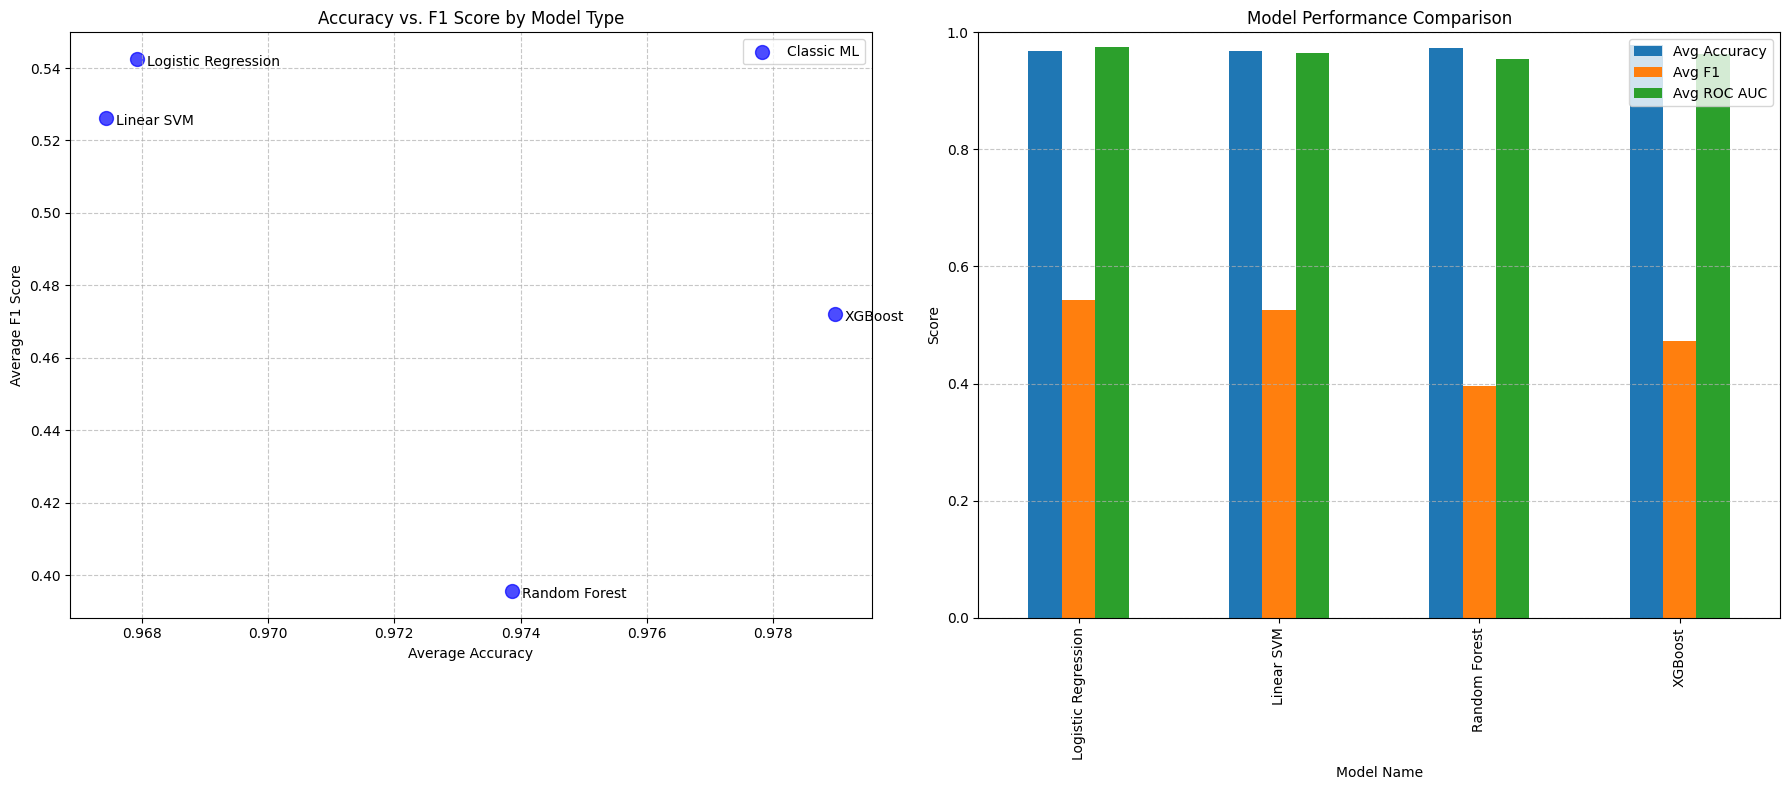

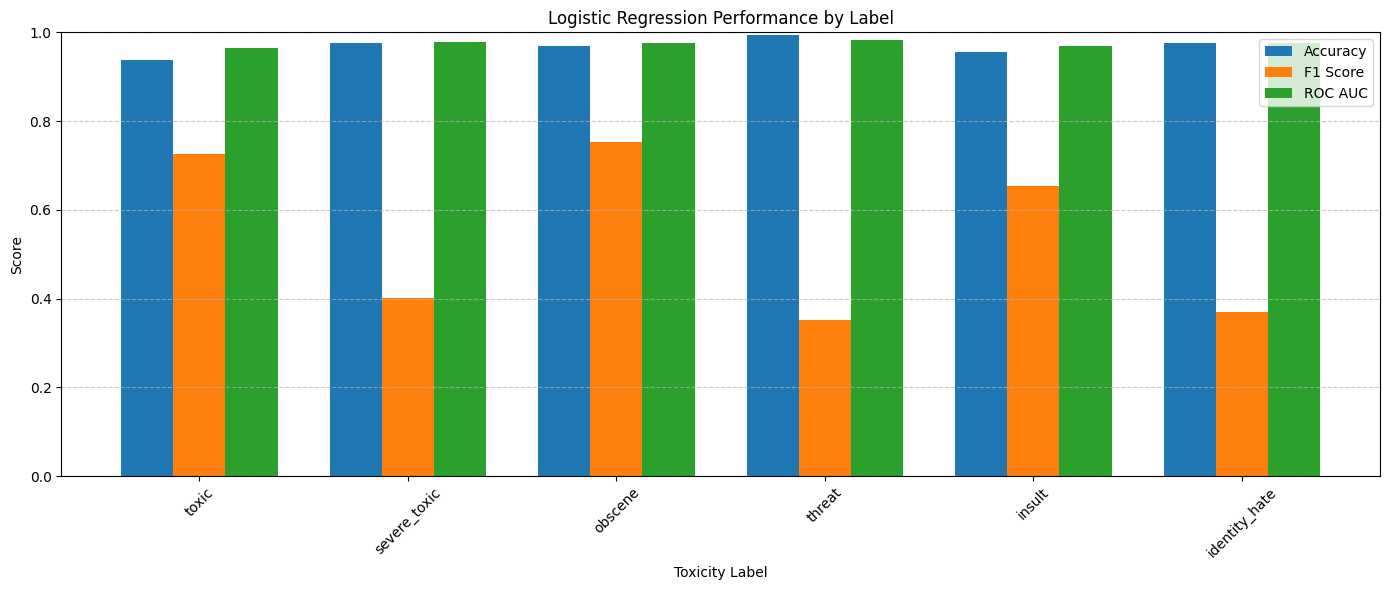

In [ ]:
# Visualization and analysis of results
print(f"\n{'='*50}")
print(f"Performance Visualization and Analysis")
print(f"{'='*50}")

# Combine results for comparison
comparison_data = []

# Add classic model results
if classic_results:
    for model_name, result in classic_results.items():
        comparison_data.append({
            'Model Type': 'Classic ML',
            'Model Name': model_name,
            'Avg Accuracy': result['avg_accuracy'],
            'Avg F1': result['avg_f1'],
            'Avg ROC AUC': result['avg_roc_auc']
        })

# Add neural model results
if neural_results and 'avg_accuracy' in neural_results:
    comparison_data.append({
        'Model Type': 'Neural',
        'Model Name': 'Transformer',
        'Avg Accuracy': neural_results.get('avg_accuracy', 0),
        'Avg F1': neural_results.get('avg_f1', 0),
        'Avg ROC AUC': neural_results.get('avg_roc_auc', 0)
    })

# Create comparison DataFrame
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Performance Comparison:")
    print(comparison_df)

    # Visualize comparison
    if len(comparison_df) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Scatter plot for accuracy vs F1
        ax = axes[0]
        model_types = comparison_df['Model Type'].unique()
        colors = ['blue', 'green', 'red', 'orange', 'purple']

        for i, model_type in enumerate(model_types):
            model_data = comparison_df[comparison_df['Model Type'] == model_type]
            ax.scatter(
                model_data['Avg Accuracy'],
                model_data['Avg F1'],
                label=model_type,
                alpha=0.7,
                s=100,
                color=colors[i % len(colors)]
            )

            # Add model name annotations
            for _, row in model_data.iterrows():
                model_name = row['Model Name']
                if isinstance(model_name, str) and '/' in model_name:
                    model_name = model_name.split('/')[-1]
                ax.annotate(
                    model_name,
                    (row['Avg Accuracy'], row['Avg F1']),
                    xytext=(7, -5),
                    textcoords='offset points'
                )

        ax.set_title('Accuracy vs. F1 Score by Model Type')
        ax.set_xlabel('Average Accuracy')
        ax.set_ylabel('Average F1 Score')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        # Bar chart for all metrics
        ax = axes[1]
        comparison_df.set_index('Model Name')[['Avg Accuracy', 'Avg F1', 'Avg ROC AUC']].plot(kind='bar', ax=ax)
        ax.set_title('Model Performance Comparison')
        ax.set_ylabel('Score')
        ax.set_ylim(0, 1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

        # Per-label performance for best model
        if use_transformer and neural_results:
            plt.figure(figsize=(14, 6))

            metrics = []
            labels = []
            accuracies = []
            f1_scores = []
            roc_aucs = []

            for label in label_cols:
                accuracy = neural_results.get(f'{label}_accuracy', 0)
                f1 = neural_results.get(f'{label}_f1', 0)
                roc_auc = neural_results.get(f'{label}_roc_auc', 0)

                labels.append(label)
                accuracies.append(accuracy)
                f1_scores.append(f1)
                roc_aucs.append(roc_auc)

            x = np.arange(len(labels))
            width = 0.25

            plt.bar(x - width, accuracies, width, label='Accuracy')
            plt.bar(x, f1_scores, width, label='F1 Score')
            plt.bar(x + width, roc_aucs, width, label='ROC AUC')

            plt.xlabel('Toxicity Label')
            plt.ylabel('Score')
            plt.title('Transformer Model Performance by Label')
            plt.xticks(x, labels, rotation=45)
            plt.legend()
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

        elif not use_transformer and best_classic_model in classic_results:
            best_model_results = classic_results[best_classic_model]['label_scores']

            plt.figure(figsize=(14, 6))

            labels = []
            accuracies = []
            f1_scores = []
            roc_aucs = []

            for label, metrics in best_model_results.items():
                labels.append(label)
                accuracies.append(metrics['accuracy'])
                f1_scores.append(metrics['f1'])
                roc_aucs.append(metrics['roc_auc'])

            x = np.arange(len(labels))
            width = 0.25

            plt.bar(x - width, accuracies, width, label='Accuracy')
            plt.bar(x, f1_scores, width, label='F1 Score')
            plt.bar(x + width, roc_aucs, width, label='ROC AUC')

            plt.xlabel('Toxicity Label')
            plt.ylabel('Score')
            plt.title(f'{best_classic_model} Performance by Label')
            plt.xticks(x, labels, rotation=45)
            plt.legend()
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
else:
    print("No model comparison data available.")

Reflection: This cell creates comprehensive visualizations to analyze model performance. It compares all models' metrics (accuracy, F1, ROC AUC) in both scatter plots and bar charts, making it easy to identify strengths and weaknesses. Additionally, it creates per-label performance visualizations for the selected best model, helping understand which types of toxicity are detected more accurately. These visualizations are crucial for communicating results and making informed decisions about model selection and improvement.